# Image Classification

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.5.0


## Data setting in Google Colab.

In [3]:
# 내 구글 드라이브를 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# data
tfr_train = '/content/drive/MyDrive/Colab/oxford_pet_tfr/cls_train.tfr'
tfr_valid = '/content/drive/MyDrive/Colab/oxford_pet_tfr/cls_val.tfr'

In [5]:
# class list
cls_file = '/content/drive/MyDrive/Colab/class_list.txt'
class_list = []
with open(cls_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n','')
        class_list.append(line)

## Classification

In [6]:
IMG_SIZE = 224
N_CLASS = 37
N_TRAIN = 6000
N_VAL = 1378

In [7]:
## Hyper Parameters
N_EPOCHS = 20
N_BATCH = 32
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [8]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)

    return image, label

In [9]:
## train dataset
train_dataset = tf.data.TFRecordDataset(tfr_train)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # parsing
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [10]:
## validation dataset
val_dataset = tf.data.TFRecordDataset(tfr_valid)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)   # parsing
val_dataset = val_dataset.batch(N_BATCH).repeat()

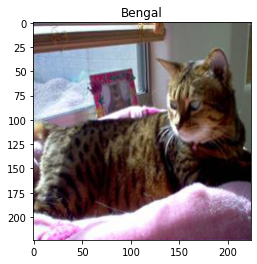

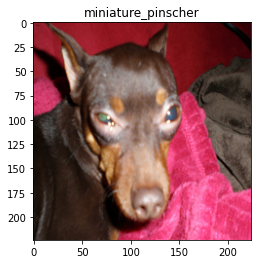

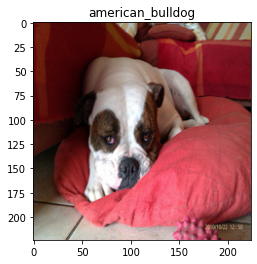

In [11]:
for image, label in train_dataset.take(3):
    plt.imshow(image[0])
    title = class_list[label[0].numpy()]
    plt.title(title)
    plt.show()

### Simple CNN Model

In [12]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model


model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps
)

Epoch 1/20
187/187 [==============================] - 55s 108ms/step - loss: 3.5901 - accuracy: 0.0393 - val_loss: 3.4657 - val_accuracy: 0.0610
Epoch 2/20
187/187 [==============================] - 16s 67ms/step - loss: 3.2808 - accuracy: 0.1062 - val_loss: 3.1629 - val_accuracy: 0.1321
Epoch 3/20
187/187 [==============================] - 15s 67ms/step - loss: 2.9988 - accuracy: 0.1738 - val_loss: 2.9448 - val_accuracy: 0.1821
Epoch 4/20
187/187 [==============================] - 15s 67ms/step - loss: 2.7855 - accuracy: 0.2205 - val_loss: 2.8481 - val_accuracy: 0.1981
Epoch 5/20
187/187 [==============================] - 15s 67ms/step - loss: 2.5659 - accuracy: 0.2763 - val_loss: 2.7916 - val_accuracy: 0.2293
Epoch 6/20
187/187 [==============================] - 15s 67ms/step - loss: 2.3150 - accuracy: 0.3480 - val_loss: 2.6963 - val_accuracy: 0.2540
Epoch 7/20
187/187 [==============================] - 15s 67ms/step - loss: 1.9927 - accuracy: 0.4328 - val_loss: 2.6744 - val_accuracy

### Batch normalization & learning rate scheduler 적용



In [14]:
# Sequential API를 사용하여 model 구성
def create_bn_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())    
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

model = create_bn_model()

## learning rate scheduing
## 5 epoch 마다 1/2로 줄임
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

In [15]:
history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps
)

Epoch 1/20
187/187 [==============================] - 21s 93ms/step - loss: 3.1940 - accuracy: 0.1580 - val_loss: 5.1725 - val_accuracy: 0.0428
Epoch 2/20
187/187 [==============================] - 20s 91ms/step - loss: 1.7256 - accuracy: 0.5435 - val_loss: 5.1020 - val_accuracy: 0.0617
Epoch 3/20
187/187 [==============================] - 20s 89ms/step - loss: 0.7357 - accuracy: 0.8793 - val_loss: 3.0064 - val_accuracy: 0.2192
Epoch 4/20
187/187 [==============================] - 20s 90ms/step - loss: 0.2200 - accuracy: 0.9915 - val_loss: 2.6978 - val_accuracy: 0.2823
Epoch 5/20
187/187 [==============================] - 20s 91ms/step - loss: 0.0758 - accuracy: 0.9995 - val_loss: 2.5560 - val_accuracy: 0.3106
Epoch 6/20
187/187 [==============================] - 20s 90ms/step - loss: 0.0394 - accuracy: 1.0000 - val_loss: 2.4968 - val_accuracy: 0.3244
Epoch 7/20
187/187 [==============================] - 20s 90ms/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 2.4926 - val_accuracy:

### Pretrained MobileNetV2 사용

1.   depthwise (= channel) convolution + pointwise convolution
  - 3x3 Conv - BN - ReLU - 1x1 Conv - BN - ReLU

2.   Inverted Residuals
3.   Linear Bottlenecks




In [16]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [17]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
# keras.utils.plot_model(mobilenetv2)
# last layer : (None, 7, 7, 1280)

In [21]:
def create_mv_model():
    model = models.Sequential()
    model.add(mobilenetv2)
    model.add(GlobalAveragePooling2D())  
    model.add(Dense(N_CLASS, activation='softmax'))
    return model


model = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps
)

Epoch 1/20
187/187 [==============================] - 52s 234ms/step - loss: 1.1144 - accuracy: 0.7200 - val_loss: 0.6441 - val_accuracy: 0.7939
Epoch 2/20
187/187 [==============================] - 44s 219ms/step - loss: 0.2332 - accuracy: 0.9363 - val_loss: 0.5433 - val_accuracy: 0.8222
Epoch 3/20
187/187 [==============================] - 45s 222ms/step - loss: 0.1004 - accuracy: 0.9802 - val_loss: 0.4578 - val_accuracy: 0.8498
Epoch 4/20
187/187 [==============================] - 44s 220ms/step - loss: 0.0502 - accuracy: 0.9928 - val_loss: 0.3963 - val_accuracy: 0.8752
Epoch 5/20
187/187 [==============================] - 44s 221ms/step - loss: 0.0316 - accuracy: 0.9957 - val_loss: 0.3247 - val_accuracy: 0.8991
Epoch 6/20
187/187 [==============================] - 44s 222ms/step - loss: 0.0208 - accuracy: 0.9982 - val_loss: 0.3048 - val_accuracy: 0.9006
Epoch 7/20
187/187 [==============================] - 44s 221ms/step - loss: 0.0152 - accuracy: 0.9985 - val_loss: 0.3051 - val_ac